## Hey guys!!

### I got really captivated the way GM Abhishek Thakur developed the UNet architecture in [this](https://www.youtube.com/watch?v=u1loyDCoGbE) video and thus I also tried to follow and implement the same.

### I have explained the steps in between for better understanding and have concluded with an example.

### Paper can be found [here](https://arxiv.org/pdf/1505.04597.pdf)

In [1]:
import os
import torch
import torch.nn as nn

Double Conv function is used to perform Two-stepped convolution at once. It is merely a two convolutional layer network taking the input in form of Number of Channels and gives away the modified channelled image.

In [2]:
def double_conv(in_c, out_c):
    
    conv= nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size= 3),
        nn.ReLU(inplace= True),
        nn.Conv2d(out_c, out_c, kernel_size= 3),
        nn.ReLU(inplace= True)
    )
    return conv

In the UNet paper, while building the decoder part of UNet, the **N**th level feature map of decoder is concatenated with the corresponding level feature map from encoder side. Since the feature map on encoder side is consistently larger than the corresponding level feature map on decoder size, we define a crop image function to crop the encoder feature map.

In [3]:
def cropimg(start_tensor, end_tensor):
    ssize= start_tensor.size()[2]
    esize= end_tensor.size()[2]
    
    delta= ssize-esize
    delta= delta//2
    
    return start_tensor[:,:,delta:ssize-delta, delta:ssize-delta]

### This is the crux of the whole code...Cover all the bases and get charged!!
At this step, the basic UNet model is defined. Encoder and Decoder parts are defined using Down Convolution and UpConvolution. 

In [4]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.maxpool_2x2 = nn.MaxPool2d(kernel_size= 2, stride= 2)
        self.dconv1= double_conv(1,64)
        self.dconv2= double_conv(64,128)
        self.dconv3= double_conv(128,256)
        self.dconv4= double_conv(256,512)
        self.dconv5= double_conv(512,1024)
        
        #Now, the first up convolution is performed followed by a double convolution to alter the number of channels of feature map.
        self.uptrans1= nn.ConvTranspose2d(
            in_channels= 1024,
            out_channels= 512,
            kernel_size= 2,
            stride= 2
        )
        
        self.upconv1= double_conv(1024,512)
        
        self.uptrans2= nn.ConvTranspose2d(
            in_channels= 512,
            out_channels= 256,
            kernel_size= 2,
            stride= 2
        )
        
        self.upconv2= double_conv(512, 256)
        
        self.uptrans3= nn.ConvTranspose2d(
            in_channels= 256,
            out_channels= 128,
            kernel_size= 2,
            stride= 2
        )
        
        self.upconv3= double_conv(256,128)
        
        self.uptrans4= nn.ConvTranspose2d(
            in_channels= 128,
            out_channels= 64,
            kernel_size= 2,
            stride= 2
        )
        
        self.upconv4= double_conv(128,64)
        
        self.out= nn.Conv2d(
            in_channels= 64,
            out_channels= 1,
            kernel_size= 1
            )
    
    def forward(self, image):
        
        #encoder
        x1= self.dconv1(image)
        x2= self.maxpool_2x2(x1)
        x3= self.dconv2(x2)
        x4= self.maxpool_2x2(x3)
        x5= self.dconv3(x4)
        x6= self.maxpool_2x2(x5)
        x7= self.dconv4(x6)
        x8= self.maxpool_2x2(x7)
        x9= self.dconv5(x8)
        
        #decoder
        x= self.uptrans1(x9)
        y= cropimg(x7,x)
        x= self.upconv1(torch.cat([x,y],1))
        
        x= self.uptrans2(x)
        y= cropimg(x5,x)
        x= self.upconv2(torch.cat([x,y],1))
        
        x= self.uptrans3(x)
        y= cropimg(x3,x)
        x= self.upconv3(torch.cat([x,y],1))
        
        x= self.uptrans4(x)
        y= cropimg(x1,x)
        x= self.upconv4(torch.cat([x,y],1))
        
        x= self.out(x)
        print(x.size())
        return x

### Doing the dishes now...

In [5]:
if __name__== '__main__':
    image= torch.rand((1,1,572,572))
    model= UNet()
    x= model(image)

torch.Size([1, 1, 388, 388])


For plotting the images, we now convert the tensors into numpy arrays for matplot to work

In [6]:
x= x.reshape(388,388)
x.size()
x= x.detach().numpy()
image= image.reshape(572,572)
image= image.detach().numpy()

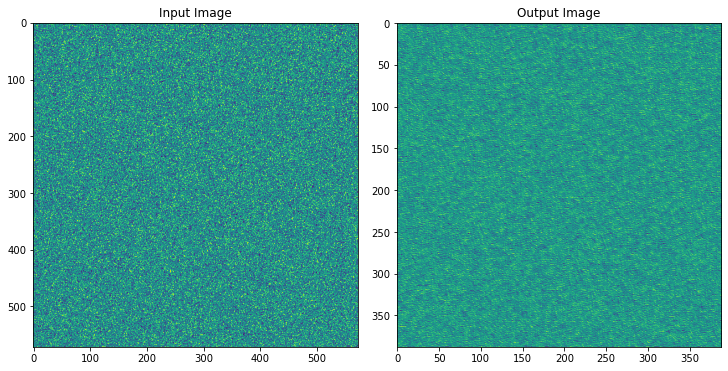

In [7]:
import matplotlib.pyplot as plt

f,ax= plt.subplots(1,2, constrained_layout=True, figsize= (10,10))

ax[0].set_title('Input Image')
ax[0].imshow(image)

ax[1].set_title('Output Image')
ax[1].imshow(x)

### We can conclude that the output image has reduced noice and thus is more clear.